In [33]:
import time
#import retro
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers

import numpy as np
import cv2
#import keyboard
import gym
import matplotlib.pylab as plt
from IPython.display import clear_output
#retro.data.list_games()

In [34]:
#obs, rew, done, info = env.step(env.action_space.sample())
#(224, 240, 3)
#MultiBinary(9)                          
class RAM_ANN():
  def __init__(self, action_space, frameskip, seed):
    initializer1 = initializers.GlorotUniform (seed = seed+1)
    initializer2 = initializers.GlorotUniform (seed = seed+2)
    initializer3 = initializers.GlorotUniform (seed = seed+3)
    initializer4 = initializers.GlorotUniform (seed = seed+4)

    self.frameskip = frameskip
    self.action_space = len(action_space)
    num_actions = self.action_space
    #NN layers
    ram_input = layers.Input(shape=(128,self.frameskip))
    #preprocessor = layers.experimental.preprocessing.Resizing(84, 84, interpolation='bilinear', name=None)(image_input)
    # Convolutions on the frames on the screen
    #data_format='channels_first'
    layer4 = layers.Flatten()(ram_input)
    layer5 = layers.Dense(128, activation="relu", kernel_initializer = initializer1)(layer4)
    layer6 = layers.Dense(128, activation="relu", kernel_initializer = initializer2)(layer5)
    layer7 = layers.Dense(128, activation="relu", kernel_initializer = initializer3)(layer6)
    action = layers.Dense(num_actions, activation="linear", kernel_initializer = initializer4)(layer7)

    #Define NN parameters.
    self.toymodel = keras.Model(inputs=ram_input, outputs=action)
    self.loss_fn = tf.keras.losses.Huber()
    self.optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
    self.toymodel.compile(self.optimizer, self.loss_fn)

  def trainStep(self, sample_X, sample_Y):
    with tf.GradientTape() as tape:
      old_q = self.toymodel(sample_X, training=True)
      loss_value = self.loss_fn(sample_Y, old_q)
    grads = tape.gradient(loss_value, self.toymodel.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.toymodel.trainable_weights))
    return loss_value.numpy()

  def train(self, x_input, y_input, batchsize=64):
    loss_history = []
    dataset = tf.data.Dataset.from_tensor_slices((x_input, y_input))
    dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
    for steps, (x, y) in enumerate(dataset):
      loss_history.append(self.trainStep(x,y))
    return loss_history

  def forward(self, x_input):
    return self.toymodel(x_input)

In [70]:
#@title
class Agent_RAM():
    def __init__(self,runname, env, action_space):
        self.seed = 42
        self.action_space = action_space
        self.env = env
        self.env.seed(self.seed)
        self.steps_taken = 0 
        self.runname = runname
        self.epsilon = 1.0
        self.epsilon_max = 1.0
        self.epsilon_min = 0.05
        self.epsilon_lag = 50000
        self.annealing_time = 1000000
        self.len_of_episode = 10000
        self.gamma = 0.80
        self.max_memory_len = 100000
        self.steps_per_update = 100
        self.batch_size = 32
        self.loss_history = []
        self.action_history = []
        self.state_history= []
        self.next_state_history = []
        self.reward_history = []
        self.done_history = []
        self.episodic_return = []
        self.return_history = [] 
        self.frameskip = 8 
        self.behavior = RAM_ANN(self.action_space, self.frameskip, self.seed)
        self.target = RAM_ANN(self.action_space,self.frameskip, self.seed)
        self.target_update = 100
        
    def popback(self, state_block, incoming_state):
        state_block.pop(0)
        state_block.append(incoming_state)
        return state_block

    def gradient_update(self, 
                        runname,
                        state_history, 
                        next_state_history,
                        rewards_history,
                        action_history,
                        loss_history,
                        model,
                        target_model,
                        gamma,
                        batch_size,
                        done_history,
                        action_space,
                        seed,
                        steps):
            np.random.seed(seed+steps)
            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)
            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            next_state_sample = np.array([next_state_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor([float(done_history[i]) for i in indices])
            future_rewards = target_model.toymodel.predict(next_state_sample)
            updated_q_values = rewards_sample + gamma * tf.reduce_max(future_rewards, axis=1)
            updated_q_values = updated_q_values *(1-done_sample) - done_sample
            updated_q_values = np.interp(updated_q_values, (-1, np.max(updated_q_values)), (-1,1))        #Normalize the rewards. 
            masks = tf.one_hot(action_sample, len(action_space))
            with tf.GradientTape() as tape:  
                q_values = model.toymodel(state_sample)
                q_actions = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                loss = model.loss_fn(updated_q_values, q_actions)
            loss_history.append(loss)
            grads = tape.gradient(loss, model.toymodel.trainable_variables)
            model.toymodel.optimizer.apply_gradients(zip(grads, model.toymodel.trainable_variables))
            
            #np.save(runname + 'loss_function_history', loss_history)
            
    def save_history(self,
                     runname,
                     action_history,
                     state_history,
                     next_state_history,
                     reward_history,
                     done_history,
                     return_history):            
        np.save(runname + 'action_history',action_history)
        np.save(runname + 'state_history', state_history)
        np.save(runname + 'next_state_history', next_state_history)
        np.save(runname + 'reward_history', reward_history)
        np.save(runname + 'done_history', done_history)
        np.save(runname + 'return_history', return_history)   

    def preprocess(self, image):
        return np.array(image/255).astype('float16')

    def memory_manager(self,array, mem_size):
        num_delete = len(array) - mem_size
        if num_delete < 0:
            None
        else:
            del array[:num_delete]
            
    def piecewise_epsilon(self, steps_taken, lag, annealingtime, ep_min, ep_max): #returns epsilon
        anneal_slope= (ep_min-ep_max)/(lag+annealingtime-lag)
        if steps_taken < lag: return ep_max
        if (steps_taken >= lag) and (steps_taken < (lag+annealingtime)): return anneal_slope*steps_taken+(ep_max-anneal_slope*lag)
        else: return ep_min
        
    def episode(self,num_episodes):    #Double Deep Q
        np.random.seed(self.seed+self.steps_taken)
        for episode_number in range (num_episodes):
            
            #Calculate epsilon using a piecewise function.
            self.epsilon = self.piecewise_epsilon(self.steps_taken, self.epsilon_lag, self.annealing_time, self.epsilon_min, self.epsilon_max)
                
            lives = 5     #5 for Breakout, 3 for Space Invaders
            s = []
            s.append(self.preprocess(self.env.reset()))
            #Setup initial environment.                                                            #FUNCTIONIZE
            #Prime the state s with 3 frames.
            epi_return = 0 
            for i in range(self.frameskip-1):
                frame, r, done, info = self.env.step(self.action_space[1])
                epi_return += r
                s.append(self.preprocess(frame))

            done = False
            
            #Choose an initial action.
            
            if np.random.random() < np.max([self.epsilon,self.epsilon_min]):
                a = np.random.choice(np.arange(len(self.action_space)))

            else: 
                a_probs = self.behavior.toymodel(np.expand_dims(np.dstack(s)[0],0), training=False)
                a = tf.argmax(a_probs[0]).numpy()

            #Enter the loop.
            for step_in_episode in range (self.len_of_episode):
                reward = 0
                #Skip 4 frames.
                new_frame, r, done, info = self.env.step(self.action_space[a])
                s_prime = self.popback(s, self.preprocess(new_frame))
                reward += r
                #for j in range(self.frameskip-1): #If you want to repeat actions enable this line.
                #  new_frame, r, done, info = self.env.step(self.action_space[a])
                #  s_prime = self.popback(s_prime, self.preprocess(new_frame))
                #  reward += r        
                
                epi_return += reward
                #self.env.render()
                #Restart when the end of the episode is reached.  
                if done:                                                                              #FUNCTIONIZE!
                    #Set the last frame to -1 to discourage dying.                                             
                    self.done_history[-1] = True                       
                    self.episodic_return.append(epi_return)
                    break
                #Monitor the the number of lives from the environemtnt. If the number of lives is reduced, then the player has died. Reset the level.  FUNCTIONIZE!
                if not (int(info['ale.lives']) == lives):                                         
                    self.done_history[-1] = True 
                    self.episodic_return.append(epi_return)
                    #print ('Episode finished in ', step_in_episode, 'steps.')
                    break
                    #epi_return = 0
                    #reward = 0
                    #lives = info['ale.lives'] #Reduce the number of lives.
                    #s = []
                    ##Prime the state s with 4 frames. Don't restart environment. Keep playing the same level. Prime with 4 frames while hitting "FIRE" to start next round.
                    #epi_return = 0 
                    #for i in range(self.frameskip):
                    #    frame, reward, done, info = self.env.step(self.action_space[1])
                    #    epi_return += reward
                    #    s.append(self.preprocess(frame))
                    #if np.random.random() < np.max([self.epsilon,self.epsilon_min]):
                    #    a = np.random.choice(np.arange(len(self.action_space)))
                    #else: 
                    #    a_probs = self.behavior.toymodel(np.expand_dims(np.dstack(s)[0],0), training=False)
                    #    a = tf.argmax(a_probs[0]).numpy()
                    #reward = 0
                    ##Skip 4 frames.
                    #new_frame, r, done, info = self.env.step(self.action_space[a])
                    #s_prime = self.popback(s, self.preprocess(new_frame))
                    #reward += r
                    #for j in range(self.frameskip-1): 
                    #  new_frame, r, done, info = self.env.step(self.action_space[a])
                    #  s_prime = self.popback(s_prime, self.preprocess(new_frame))
                    #  reward += r                    

                #Save to history
                self.reward_history.append(reward)
                self.state_history.append(np.dstack(s)[0])
                self.action_history.append(a)
                self.next_state_history.append(np.dstack(s_prime)[0])
                self.done_history.append(done)
                 
                if len(self.reward_history)>self.batch_size and self.steps_taken%self.steps_per_update==0:
                    self.gradient_update(self.runname,
                                         self.state_history, 
                                         self.next_state_history,
                                         self.reward_history,
                                         self.action_history,
                                         self.loss_history,
                                         self.behavior, 
                                         self.behavior, #add behavior here to make it single Q-learning,
                                         self.gamma,
                                         self.batch_size,
                                         self.done_history,
                                         self.action_space,
                                         self.seed,
                                         self.steps_taken)
                    
                if self.steps_taken%self.target_update==0:
                    self.target.toymodel.set_weights(self.behavior.toymodel.get_weights())   

                if np.random.random() < np.max([self.epsilon,self.epsilon_min]):
                    a_prime = np.random.choice(np.arange(len(self.action_space)))

                else:
                    a_probs = self.behavior.toymodel(np.expand_dims(np.dstack(s_prime)[0],0), training=False)
                    a_prime = tf.argmax(a_probs[0]).numpy()

                    #print ('Nonrandom action taken. ', a_prime)

                s = s_prime
                a = a_prime
                self.steps_taken += 1
                self.memory_manager(self.action_history, self.max_memory_len)
                self.memory_manager(self.state_history, self.max_memory_len)
                self.memory_manager(self.next_state_history, self.max_memory_len)
                self.memory_manager(self.reward_history, self.max_memory_len)
                self.memory_manager(self.done_history, self.max_memory_len)
            #self.save_history(self.runname,
            #                  self.action_history,
            #                  self.state_history,
            #                  self.next_state_history,
            #                  self.reward_history,
            #                  self.done_history,
            #                  self.return_history)
            self.episodic_return.append(epi_return)
            #self.env.close()
            if self.steps_taken%100==0:
              clear_output()
              print ('Epsilon is at ', self.epsilon, ' as of step ', self.steps_taken)
              plt.figure(figsize=(10,2))
              plt.plot(np.arange(len(self.episodic_return)), self.episodic_return)
              plt.xlabel('Episode')
              plt.ylabel('Return')
              plt.show()
              plt.figure(figsize=(10,2))
              plt.plot(np.arange(len(self.loss_history)), self.loss_history)
              plt.xlabel('Training Step')
              plt.ylabel('Loss')
              plt.show()
        #self.behavior.toymodel.save('120228_Breakout')

In [71]:
env1 = gym.make('Breakout-ram-v4')
atari_action_space = np.arange(4)
# 'BreakoutNoFrameskip-v4'
# 'SpaceInvaders-v0'

Epsilon is at  0.05  as of step  1250700


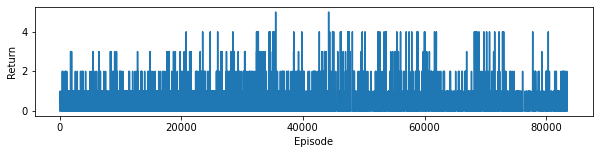

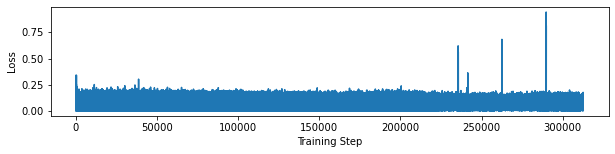

KeyboardInterrupt: 

In [74]:
agent = Agent_RAM('210331_1', env1, atari_action_space)
agent.epsilon = 1.0
agent.epsilon_max = 1.0
agent.epsilon_min = 0.05
agent.epsilon_lag = 50000
agent.annealing_time = 1000000
agent.len_of_episode = 10000
agent.gamma = 0.99
agent.max_memory_len = 100000
agent.steps_per_update = 4
agent.target_update = 10000
agent.frameskip = 8
agent.episode(1000000000000)